In [3]:
from d2l import torch as d2l
import torch
import torchvision
from torchvision import transforms
from torch.utils import data

# Reading the Data
We'll be looking at the Fashion-MNIST dataset

In [5]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root = '../data', train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root = '../data', train=False, transform=trans, download=True)

In [6]:
len(mnist_train), len(mnist_test)

(60000, 10000)

The images are grayscale -- one color channel; 28 by 28.

In [8]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [15]:
# Function to associate labels with integers
def get_fashion_mnist_labels(labels):
    """Return text labels for Fashion-MNISTdataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

Now we want to visualize these examples. This will also let us check our prior function to make sure we can correctly associate labels with images.

In [16]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows*scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax,img) in enumerate(zip(axes,imgs)):
        ax.imshow(d2l.numpy(img))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

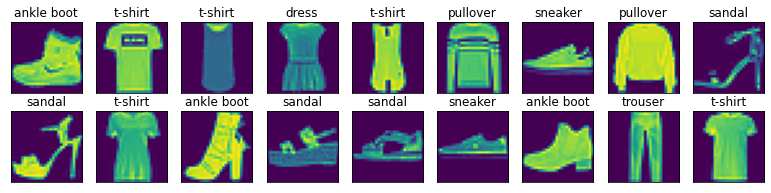

In [17]:
X,y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18,28,28), 2, 9, titles=get_fashion_mnist_labels(y));

## Reading a Minibatch

In [32]:
batch_size = 64

def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers = get_dataloader_workers())

In [33]:
%%time
for X,y in train_iter:
    continue

CPU times: user 762 ms, sys: 391 ms, total: 1.15 s
Wall time: 3.54 s


## Putting it all together
Now we write one function to download and create iterators from the fashion mnist data.

In [21]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the fashion-mnist dataset and load it into memory"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root = '../data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root = '../data', train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                           num_workers = get_dataloader_workers()),
           data.DataLoader(mnist_test, batch_size, shuffle=False,
                          num_workers = get_dataloader_workers()))
    

In [22]:
# Test the image resize feature
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X,y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


And now we can work with the fashion mnist dataset. We have written functions to do many of the things `fastai` does automatically. This brings a little more transparency to the process. Though I would still need to figure out exactly what a PyTorch `DataLoader` is doing. At this point it seems like it's mostly about batch size management.

## Exercises from 3.5
1. Reducing the batch size to 1 drastically increases the time it takes to load the data. Have we experienced this in fastai? Went from around 2.5 seconds to around two minutes (going from batch size 64 to batch size 1)
2. Is the data iterator fast enough? Probably not for larger datasets. Though at the end of the day I'm fundamentally limited by working on a laptop from 2011. Can investigate this question further as I go through the pytorch book eventually.

# Implementation of Softmax Regression from Scratch
We will now implement softmax regression from scratch and apply it to the MNIST-Fashion dataset. Perhaps I can present on this -- maybe using normal MNIST, maybe using something else entirely -- on Tuesday. Though maybe just on fashion MNIST as we haven't explored this dataset yet.

In [34]:
batch_size = 256
# the method we wrote above is in the d2l library
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Initialize Model Parameters
We will treat each image as a vector of length $28 \times 28 = 784$. Each pixel location is a feature. We will have an output dimension of 10 (as we have ten categories). So our weights will be size $784 \times 10$, and the biases will comprise a $1 \times 10$ row vector. We will initiate our weights to Gaussian noise and our biases to zero.

In [35]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0,0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## Defining the Softmax Operation
Recall the three steps of the softmax operation:
1. exponentiate each term
2. sum over each to get the normalization constant for each example
3. divide each row by its normalization constant

I believe "term" in this case will refer to the ten outputs.

$$\text{softmax}(\mathbf{X}_{ij}) = \frac{\exp{(\mathbf{X}_{ij})}}{\sum_k\exp{(\mathbf{X}_{ik})}}$$

In [36]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # broadcasting is applied here

In [37]:
# Example
X = torch.normal(1,1,(2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(1), X

(tensor([[0.5967, 0.0604, 0.1070, 0.1404, 0.0955],
         [0.0832, 0.3734, 0.4716, 0.0512, 0.0207]]),
 tensor([1., 1.]),
 tensor([[ 2.3881,  0.0977,  0.6692,  0.9412,  0.5564],
         [ 0.5724,  2.0732,  2.3067,  0.0857, -0.8204]]))

## Defining the Model

In [38]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

So, looking at this more closely: we first reshape X into a vector and multiply it by our weight matrix W and add our biases b. So we have a (1 x 784) * (784 x 10) matrix multiplication returning a (1x10) vector, to which we add the biases (1 x 10), and then take the softmax to get ten class probability estimates.

## Loss Function
For cross-entropy loss

In [39]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)),y])

## Measure Accuracy
We want to choose the class with the highest predicted probability whenever we actually need to produce a prediction.

In [40]:
def accuracy(y_hat, y):
    """Compute number of correct predictions"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(d2l.reduce_sum(cmp.type(y.dtype)))

In [42]:
# use functions already defined in book; not very interpretable code at this point so not worth the time
d2l.evaluate_accuracy(net, test_iter)

0.0705

## Training an Epoch

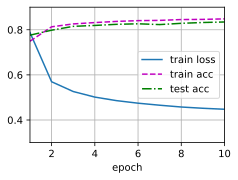

In [43]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 10
d2l.train_ch3(net,train_iter,test_iter,cross_entropy,num_epochs,updater)

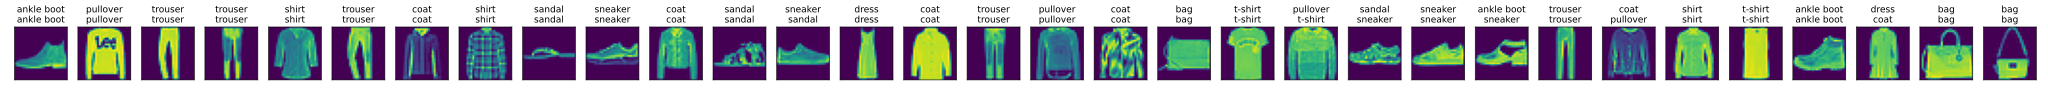

In [46]:
d2l.predict_ch3(net, test_iter, n=32)

# Concise Implementation

In [47]:
from torch import nn

In [48]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [50]:
# init weights
class Reshape(torch.nn.Module):
    def forward(self,x):
        return x.view(-1,784)

net = nn.Sequential(Reshape(), nn.Linear(784,10))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Reshape()
  (1): Linear(in_features=784, out_features=10, bias=True)
)

## Softmax Revisited
Computationally, the exponentiation step of softmax can be a source of numerical instability issues. If some of the logits are very large, the exponent $\exp{(o_k)}$ might be larger than the largest allowable number (overflow), making the softmax denominator infinity and resulting in `0`/`nan`/`inf` situations.

We know we ultimately intend to take the log (in the crossent loss). We can combine the two operations and escape the potential instability issues. Torch's cross entropy loss does this for us.

In [51]:
loss = nn.CrossEntropyLoss()

In [52]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

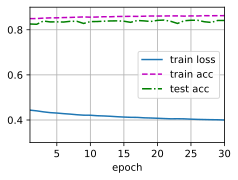

In [54]:
num_epochs=30
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)